<a href="https://colab.research.google.com/github/klsharma22/TensorflowCertifcationCourse/blob/main/10_time_series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with Milestone project

## Get data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-03-18 19:17:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2024-03-18 19:17:01 (6.75 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-18 19:18:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-18 19:18:00 (48.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Importing data with pandas

In [3]:
# Import pandas
import pandas as pd
# Let's read the data and parse it
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates= ['Date'],
                 index_col= ['Date']) # parse date and telling pandas that column 1 is datetime

df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
# How many samples do we have
len(df)

2787

> **Note**: **Seasonality** pf a time series data is referd as the number of samples per year. For outr BitCoin prediction the seasonality is of daily so we will have 365 data per year

In [11]:
# Creating a new dataframe
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns= {'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Text(0.5, 1.0, 'Price of Bitcoin from 1 October 2013 to 18 May 2021')

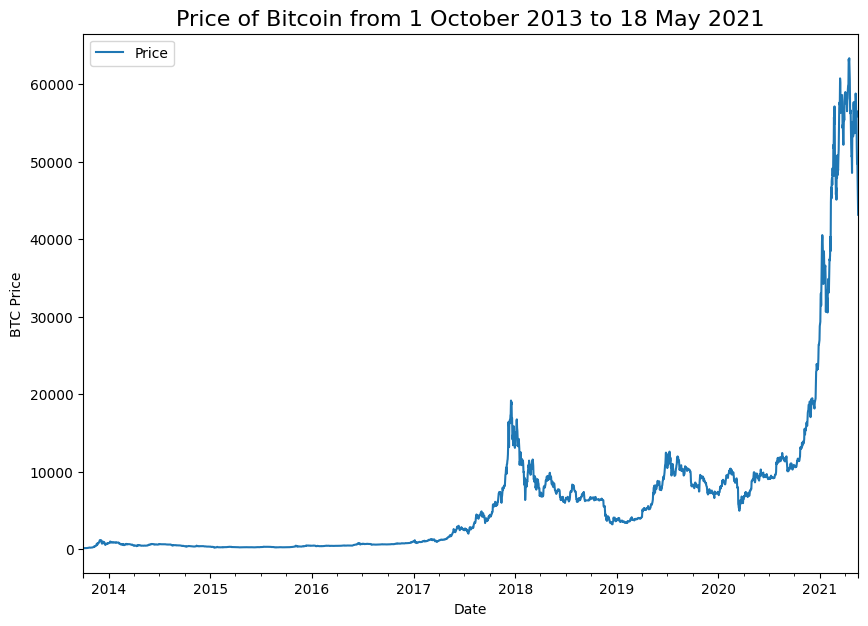

In [12]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize= (10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 October 2013 to 18 May 2021", fontsize= 16)

## Importing time series data using csv module

In [15]:
# Importing historical data with csv module
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 'r') as f:
  csv_reader = csv.reader(f, delimiter= ',')
  next(csv_reader) # This skips the header
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], '%Y-%m-%d')) # get the dates as dates and not string
    btc_price.append(float(line[2])) # get closing price

# View first 10 of each
timesteps[:10], btc_price[:10]


([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 1.0, 'Price of Bitcoin from 1 October 2013 to 18 May 2021')

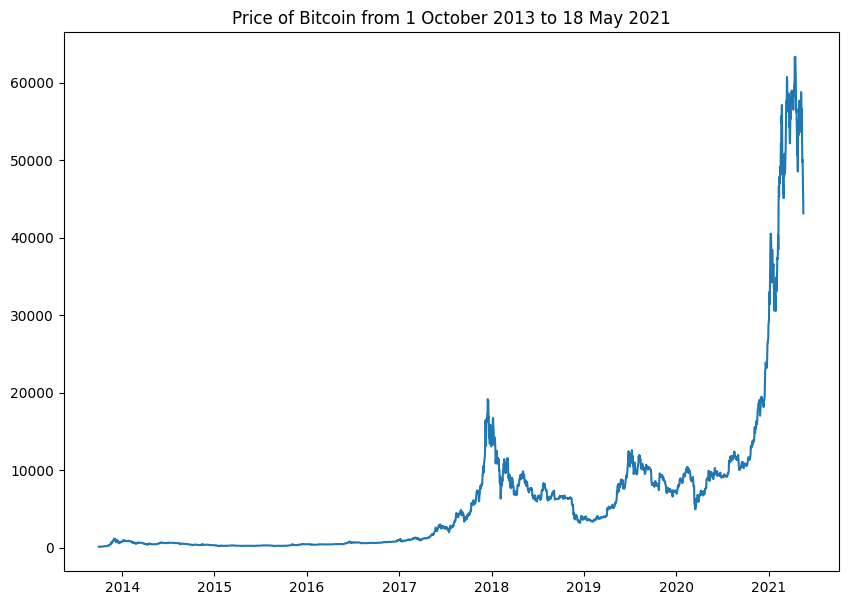

In [18]:
# Plot from the above data
plt.figure(figsize= (10, 7))
plt.plot(timesteps, btc_price)
plt.title('Price of Bitcoin from 1 October 2013 to 18 May 2021')

In [ ]:
## Format data Part 1: Create train and test splits